In [1]:
import numpy as np
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
from pathlib import Path
from astropy.io import fits
from astropy.wcs import WCS
import os
import scipy.stats as stats
import json
from shapely import LineString, MultiPoint, Polygon, centroid
import pandas as pd
from fitsutil import subsample_eventlist


This code retrieves the significance of the peak from the JSON file created by bc_imaging_analysis.py

In [2]:
def get_peaksig_json(json_path):
    with open(json_path, 'r') as file:
        json_data = json.load(file)
    
    peaksig = json_data["peaksig"]

    return peaksig

The code below takes a 2D array and fits a gaussian to it

In [3]:
def fit_rotated_2d_gaussian(data, x=None, y=None, plot_result=False,iter = None):
    """
    Fit a rotated 2D Gaussian to 2D data using Astropy's Gaussian2D model.

    Parameters:
        data : 2D numpy array
            The input data array to fit.
        x, y : 2D numpy arrays, optional
            Meshgrid coordinates corresponding to data. If None, will be auto-generated.
        plot_result : bool
            Whether to plot the original data and fit result.

    Returns:
        fitted_model : Gaussian2D
            The best-fit Gaussian2D model.
    """
    # Generate coordinate grids if not provided
    ny, nx = data.shape
    if x is None or y is None:
        y, x = np.mgrid[:ny, :nx]

    # Estimate initial parameters
    amplitude_init = np.max(data)
    x_mean_init = x[data == amplitude_init][0]
    y_mean_init = y[data == amplitude_init][0]

    # Initial guess for model
    gauss_init = models.Gaussian2D(amplitude=amplitude_init, x_mean=x_mean_init,
                                   y_mean=y_mean_init, x_stddev=0.089, y_stddev=0.069, theta=0)

    # Fitting with Levenberg-Marquardt algorithm
    fitter = fitting.LevMarLSQFitter()
    fitted_model = fitter(gauss_init, x, y, data)
    covariance_matrix = fitter.fit_info['param_cov']
    if fitted_model.x_fwhm > 1 or fitted_model.y_fwhm >1 :
        print(iter)

    if plot_result:
        fit_data = fitted_model(x, y)
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(data, origin='lower', cmap='viridis')
        axes[0].set_title("Original Data")
        axes[1].imshow(fit_data, origin='lower', cmap='viridis')
        axes[1].set_title("Fitted Gaussian")
        plt.tight_layout()
        plt.show()

    return fitted_model,covariance_matrix

In [ ]:
def analyze_localization_nested(data_dir,window=10):
    data_dir = Path(data_dir)
    # take the names of all folders within the specified directory
    folder_list = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]
    
    # create a bunch of empty arrays 
    run = [None]*len(folder_list)
    anode = [None]*len(folder_list)
    detectorMode= [None]*len(folder_list)
    temp = [None]*len(folder_list)
    sweep = [None]*len(folder_list)
    vTheta = [None]*len(folder_list)
    hTheta = [None]*len(folder_list)
    '''
    theta = []
    xMean = []
    yMean =[]
    xSigma = []
    ySigma = []
    Amplitude = []
    peakSig = []
    cov = []
    validPeak = []
    pval = [] 

    '''
    theta = [None]*len(folder_list)
    xMean = [None]*len(folder_list)
    yMean =[None]*len(folder_list)
    xSigma = [None]*len(folder_list)
    ySigma = [None]*len(folder_list)
    Amplitude = [None]*len(folder_list)
    peakSig = [None]*len(folder_list)
    cov = [None]*len(folder_list)
    validPeak = [None]*len(folder_list)
    pval = [np.nan]*len(folder_list) 
    
    for a in range(len(folder_list)): 
        numTerms = len(folder_list[a].split('_'))
        if numTerms == 7:
            run[a], anode[a], detectorMode[a], temp[a], sweep[a], vTheta[a], hTheta[a] =  folder_list[a].split('_')

        elif numTerms == 6:
            run[a], anode[a], detectorMode[a], temp[a], sweep[a], vTheta[a] = folder_list[a].split('_')
            vTheta[a] = 'NA'
            hTheta[a] = 'NA'
        elif numTerms == 4:
            run[a], anode[a], detectorMode[a], temp[a] = folder_list[a].split('_') 
        elif numTerms == 3:
            run[a],vTheta[a], hTheta[a] = folder_list[a].split('_')

        # Iterate through the subsample folders within the main data directory        
        subsample_folder_list = [folder for folder in os.listdir(data_dir/Path(folder_list[a])) if os.path.isdir(os.path.join(data_dir/Path(folder_list[a]), folder))]
        for b in range(len(subsample_folder_list)):
            if os.path.isfile(f"{data_dir}/{folder_list[a]}/{subsample_folder_list[b]}/Analysis/imaging_analysis_20241217/Figures/imaging_source.png"):
                subdata_path =  Path(f"{data_dir}/{Path(folder_list[a])}/{Path(subsample_folder_list[b])}/Analysis/imaging_analysis_20241217/image_reconstruction.fits.gz")
                try:
                    d = fits.open(subdata_path) # open fits file
        
                    data = d[0].data # data contents of the fits file

                    ny, nx = data.shape
                    ym, xm = np.mgrid[:ny, :nx]

                    w = WCS(d[0].header)

                    x,y= w.array_index_to_world_values(ym,xm)
                    x = (x+(180+360)) % 360 -180

                    peak = np.max(data)
                    peak_loc = np.unravel_index(np.argmax(data),data.shape)


                    windowed_data = data[peak_loc[0]-window:peak_loc[0]+window, peak_loc[1]-window:peak_loc[1]+window]
                    x_window = x[peak_loc[0]-window:peak_loc[0]+window, peak_loc[1]-window:peak_loc[1]+window]
                    y_window = y[peak_loc[0]-window:peak_loc[0]+window, peak_loc[1]-window:peak_loc[1]+window]
            

                    shapiro_result = stats.shapiro(windowed_data, axis=0)
                    pval[a] = np.mean(shapiro_result.pvalue)

                    fitted,covariance_matrix = fit_rotated_2d_gaussian(windowed_data, x_window, y_window, plot_result=False,iter=subsample_folder_list[a])

                    validPeak[a] = True
                    xMean[a] = fitted.x_mean.value
                    yMean[a] = fitted.y_mean.value
                    xSigma[a] = fitted.x_stddev.value
                    ySigma[a] = fitted.y_stddev.value
                    Amplitude[a] = fitted.amplitude.value
                    theta[a] =fitted.theta.value
                    cov[a] = covariance_matrix
                    runout = run[a]+anode[a]+detectorMode[a]+sweep[a]+hTheta[a]+vTheta[a]
                except:
                    validPeak[a] = "corrupt Fits"
            else:
                validPeak[a] = False  
            if os.path.isfile(f"{data_dir}/{Path(folder_list[a])}/Analysis/imaging_analysis_20241217/analysis_results.json"):
                json_path = Path(f"{data_dir}/{Path(folder_list[a])}/Analysis/imaging_analysis_20241217/analysis_results.json")
                try:
                    peakSig[a] = get_peaksig_json(json_path)
                except:
                    print('no peak')
    result = {
        "xCenter" : xMean,
        "yCenter" : yMean,
        "xSigma" : xSigma,
        "ySigma" : ySigma,
        "peak" : Amplitude,
        "peakSig" : peakSig,
        "theta" : theta,
        'covMatrix' : cov
    }

    result = pd.DataFrame(result)
    return result

In [4]:
def distFromCentroid(observation,plotHist=False):
    # computes the centroid of a finite set of points, and returns the distance that each point is from that centroid
    # observation -> pandas data frame consisting of the data from fitting a gaussian 
    
    xCoord = observation['xCenter'].to_numpy(dtype = np.float32)
    yCoord = observation['yCenter'].to_numpy(dtype = np.float32)

    centroidX = np.mean(xCoord)
    centroidY= np.mean(yCoord)
    dist = np.sqrt((centroidX-xCoord)**2+(centroidY-yCoord)**2)
    if plotHist == True:
        plt.hist(dist)
    return dist



In [20]:
def analyze_localization(data_dir,window=10,plot = False ):
    data_dir = Path(data_dir)
    # take the names of all folders within the specified directory
    folder_list = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]

    theta = [None]*len(folder_list)
    xMean = [None]*len(folder_list)
    yMean =[None]*len(folder_list)
    xSigma = [None]*len(folder_list)
    ySigma = [None]*len(folder_list)
    Amplitude = [None]*len(folder_list)
    peakSig = [None]*len(folder_list)
    cov = [None]*len(folder_list)
    validPeak = [None]*len(folder_list)
    pval = [np.nan]*len(folder_list) 

    for a in range(len(folder_list)): 
        '''
        numTerms = len(folder_list[a].split('_'))
        if numTerms == 7:
            run[a], anode[a], detectorMode[a], temp[a], sweep[a], vTheta[a], hTheta[a] =  folder_list[a].split('_')

        elif numTerms == 6:
            run[a], anode[a], detectorMode[a], temp[a], sweep[a], vTheta[a] = folder_list[a].split('_')
            vTheta[a] = 'NA'
            hTheta[a] = 'NA'
        elif numTerms == 4:
            run[a], anode[a], detectorMode[a], temp[a] = folder_list[a].split('_') 
        elif numTerms == 3:
            run[a],vTheta[a], hTheta[a] = folder_list[a].split('_')
        '''
        if os.path.isfile(f"{data_dir}/{folder_list[a]}/Analysis/imaging_analysis/Figures/imaging_source.png"):
            data_path = Path(f"{data_dir}/{folder_list[a]}/Analysis/imaging_analysis/image_reconstruction.fits.gz")
            try:
                d = fits.open(data_path) # open fits file
        
                data = d[0].data # data contents of the fits file
            #shape =  data.shape

                ny, nx = data.shape
                ym, xm = np.mgrid[:ny, :nx]

                w = WCS(d[0].header)

                x,y= w.array_index_to_world_values(ym,xm)
                x = (x+(180+360)) % 360 -180

                peak = np.max(data)
                peak_loc = np.unravel_index(np.argmax(data),data.shape)
                window = 10

                windowed_data = data[peak_loc[0]-window:peak_loc[0]+window, peak_loc[1]-window:peak_loc[1]+window]
                x_window = x[peak_loc[0]-window:peak_loc[0]+window, peak_loc[1]-window:peak_loc[1]+window]
                y_window = y[peak_loc[0]-window:peak_loc[0]+window, peak_loc[1]-window:peak_loc[1]+window]

                fitted,covariance_matrix = fit_rotated_2d_gaussian(windowed_data, x_window, y_window, plot_result=plot,iter=folder_list[a])
        
                validPeak[a] = True
                xMean[a] = fitted.x_mean.value
                yMean[a] = fitted.y_mean.value
                xSigma[a] = fitted.x_stddev.value
                ySigma[a] = fitted.y_stddev.value
                Amplitude[a] = fitted.amplitude.value
                theta[a] =fitted.theta.value
                cov[a] = covariance_matrix
            except:
                validPeak[a] = "corrupt Fits"
        else:
            validPeak[a] = False  
        if os.path.isfile(f"{data_dir}/{folder_list[a]}/Analysis/imaging_analysis/analysis_results.json"):
            json_path = Path(f"{data_dir}/{folder_list[a]}/Analysis/imaging_analysis/analysis_results.json")
            try:
                peakSig[a] = get_peaksig_json(json_path)
            except:
                print('no peak')
    result = {
        "xCenter" : xMean,
        "yCenter" : yMean,
        "xSigma" : xSigma,
        "ySigma" : ySigma,
        "peak" : Amplitude,
        "peakSig" : peakSig,
        "theta" : theta,
        'covMatrix' : cov
    }

    result = pd.DataFrame(result)
    return result


<>:1: SyntaxWarning: invalid escape sequence '\A'
<>:1: SyntaxWarning: invalid escape sequence '\A'
C:\Users\ajo5182\AppData\Local\Temp\ipykernel_4500\555570432.py:1: SyntaxWarning: invalid escape sequence '\A'
  test = analyze_localization("Z:\Astro_BlackCAT\BlackCAT_Calibration_Data\LC_Calibration_Data\Raw Long Cell Data\Test",plot = True)


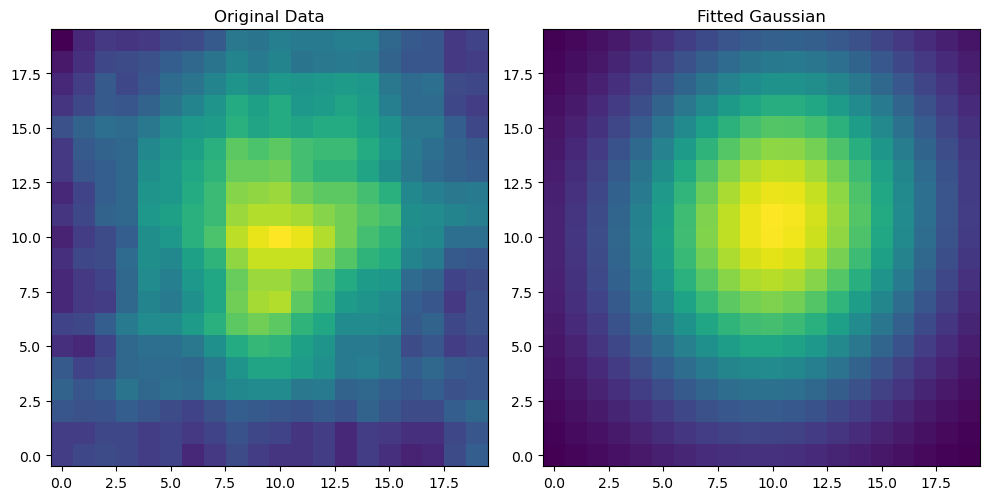

In [21]:
test = analyze_localization("Z:\Astro_BlackCAT\BlackCAT_Calibration_Data\LC_Calibration_Data\Raw Long Cell Data\Test",plot = True)

In [23]:
xlocal = (test["xSigma"]*2.355)/test['peakSig']
ylocal = (test["ySigma"]*2.355)/test['peakSig']
print(test['theta'])

0   -0.285043
Name: theta, dtype: float64


In [ ]:


subsample_eventlist(
    "Z:\Astro_BlackCAT\BlackCAT_Calibration_Data\LC_Calibration_Data\Raw Long Cell Data\y2024-12-09\BC001_Al_FF_243K_HORI_0_0\output",
    2,
    "Z:\Astro_BlackCAT\BlackCAT_Calibration_Data\LC_Calibration_Data\Raw Long Cell Data\subsampled_eventlists\test"
)

In [ ]:
data_dir = r"Z:\Astro_BlackCAT\BlackCAT_Calibration_Data\LC_Calibration_Data\Raw Long Cell Data\y2024-12-09\BC001_Al_FF_243K_HORI_0_0\output"
outdir =     r"Z:\Astro_BlackCAT\BlackCAT_Calibration_Data\LC_Calibration_Data\Raw Long Cell Data\subsampled_eventlists\BC001_Al_FF_243K_HORI_0_0"
numberOfLists = 10
runname = "BC001_Al_FF_243K_HORI_0_0"

file_list = [file for file in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, file))] 
os.mkdir(outdir)
for a in range(len(file_list)):
    d = fits.open(data_dir/Path(file_list[a]))
    data = d[1].data 
    cols = d[1].columns
    size = len(data)
    numberOfSamples = int(size/numberOfLists)
    subSampleHDU = fits.BinTableHDU.from_columns(cols)
    for n in range(numberOfLists):
        subSampleHDU.data = d[1].data[n*numberOfSamples:(n+1)*numberOfSamples]
        out = outdir/Path('subsample'+str(n))
        if os.path.isdir((out)) == False:
            os.mkdir(out)
                #print('made the directory')
            #else:
            #    print("didn't make the directory")

        subSampleHDU.writeto(out/Path(file_list[a]),overwrite=True)


In [9]:
params = [None,None,None]
params[1] = BC001_Al_FF_243K_HORI_10_0
test = {
    "name": "BC001_Al_FF_243K_HORI_10_0",
    "params":params
}

In [14]:
data_dir = Path(r"Z:\Astro_BlackCAT\BlackCAT_Calibration_Data\LC_Calibration_Data\Raw Long Cell Data\subsampled_eventlists")

folder_list = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]

params = [None]*len(folder_list)

for a in range(len(folder_list)):
    analysisDir = data_dir/Path(folder_list[a])
    params[a] = analyze_localization(analysisDir)

results = {
    "names" : folder_list,
    "params" : params 
}
    


no peak
no peak
no peak
no peak


In [11]:
results["params"]

[  xCenter yCenter xSigma ySigma  peak peakSig theta covMatrix
 0    None    None   None   None  None    None  None      None
 1    None    None   None   None  None    None  None      None
 2    None    None   None   None  None    None  None      None
 3    None    None   None   None  None    None  None      None
 4    None    None   None   None  None    None  None      None
 5    None    None   None   None  None    None  None      None
 6    None    None   None   None  None    None  None      None
 7    None    None   None   None  None    None  None      None
 8    None    None   None   None  None    None  None      None
 9    None    None   None   None  None    None  None      None,
      xCenter   yCenter    xSigma    ySigma         peak    peakSig     theta  \
 0 -10.028719  1.491188  0.083928  0.067705  1645.967125  13.930698 -0.410362   
 1        NaN       NaN       NaN       NaN          NaN  12.364029       NaN   
 2        NaN       NaN       NaN       NaN          NaN  11.32